# Stacking (with Refit)

* Training D1_D2 dataset using the `Stacking` ensemble method.
* Grid Search for best parameters
* Use `sfm` model to refit data from Features Importance experiment

### Author
Ajinkya Indulkar

In [1]:
# import libraries
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# base learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# ensemble learning - stacking
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

# metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import make_scorer, confusion_matrix

# import visualization library
from matplotlib import pyplot as plt
import seaborn as sns


# set seed (for reproducibility)
np.random.seed(43)

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

### Data Loading + Pre-processing

In [2]:
# initialize class
tp = Tadpole(debug=True)

loading tadpole dataset
pre-processing dataset


In [3]:
# train-test split
X_train, X_test, y_train, y_test = tp.split(refit=True)

splitting dataset to train and test datasets
refitting data


In [4]:
# import variables from class instance (notebook compatibility)
X, y, label_dict = tp.X, tp.y, tp.label_dict

In [5]:
# define scoring parameter
scoring = {'BA': make_scorer(balanced_accuracy_score)}

Helper Functions

In [6]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='GnBu')
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Test Data Confusion Matrix')
    plt.show()
    
def computeMetrics(model, X, y):
    """
    @description:
        function to compute performance metrics
    @arguments:
        model (sklearn) - trained model
        X (np.array) - features
        y (np.array) - target
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovr", average="macro")
    return BCA, mAUC

def report(model):
    """
    @description:
        function to report trained model performance
    @arguments:
        model (sklearn) - trained model
    """
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    BCA_train, mAUC_train = computeMetrics(model, X_train, y_train)
    BCA_test, mAUC_test = computeMetrics(model, X_test, y_test)
    print("========Model Evaluation Report========")
    print("Train Score: ", score_train)
    print("Test Score: ", score_test)
    print("=======================================")
    print("Train BCA: {:.3f} | Train AUC: {:.3f}".format(BCA_train, mAUC_train))
    print("Test BCA: {:.3f} | Test AUC: {:.3f}".format(BCA_test, mAUC_test))
    print("=======================================")
    showConfusionMatrix(model, X_test, y_test)
    return [score_train, score_test, BCA_train, BCA_test, mAUC_train, mAUC_test]

def evaluate(baselearners):
    """
    @description:
        function to evaluate base learners
    @arguments:
        baselearners (sklearn) - list of trained models
    """
    metrics = []
    for name, model in baselearners.items():
        print(name)
        results = report(model)
        metrics.append([name] + results)
    return metrics

### Base Learners: Model Training

#### Logistic Regression (LRA)

The following parameter grids were found to work best for the base learners: 
    
1. **LRA**: {'C': 0.08858667904100823, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.0001}

2. **DT**: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 0.2, 'min_samples_split': 0.5, 'splitter': 'best'}

3. **MLP**: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 
'adam'}

4. **SVM**: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear', 'tol': 1}

In [7]:
# define and train
lra = LogisticRegression(verbose=2)
lra.set_params(**{'C': 3792.690190732246, 
                  'class_weight': 'balanced', 
                  'dual': False, 
                  'penalty': 'l2', 
                  'solver': 'sag', 
                  'tol': 0.01})
lra.fit(X_train, y_train)

convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=3792.690190732246, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.01, verbose=2,
                   warm_start=False)

#### Decision Trees (DT)

In [8]:
# define and train
dtc = DecisionTreeClassifier()
dtc.set_params(**{'class_weight': 'balanced', 
                  'criterion': 'entropy', 
                  'max_depth': None, 
                  'max_features': 'auto', 
                  'min_samples_leaf': 0.1, 
                  'min_samples_split': 0.2, 
                  'splitter': 'best'})
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.1,
                       min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

#### Multi-layer Perceptron (ANN)

In [9]:
# define and train
mlp = MLPClassifier(verbose=True)
mlp.set_params(**{'activation': 'tanh', 
                  'alpha': 0.0001, 
                  'hidden_layer_sizes': (50, 100, 50), 
                  'learning_rate': 'constant', 
                  'solver': 'adam'})
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.11846237
Iteration 2, loss = 0.97775571
Iteration 3, loss = 0.85681627
Iteration 4, loss = 0.78917478
Iteration 5, loss = 0.70573337
Iteration 6, loss = 0.64334846
Iteration 7, loss = 0.58799431
Iteration 8, loss = 0.54359692
Iteration 9, loss = 0.50861003
Iteration 10, loss = 0.47748466
Iteration 11, loss = 0.45106926
Iteration 12, loss = 0.43014231
Iteration 13, loss = 0.41017752
Iteration 14, loss = 0.39371487
Iteration 15, loss = 0.38343601
Iteration 16, loss = 0.37295819
Iteration 17, loss = 0.36254758
Iteration 18, loss = 0.35489903
Iteration 19, loss = 0.35151622
Iteration 20, loss = 0.35219515
Iteration 21, loss = 0.34381275
Iteration 22, loss = 0.33559722
Iteration 23, loss = 0.33133065
Iteration 24, loss = 0.32736541
Iteration 25, loss = 0.32361410
Iteration 26, loss = 0.32150969
Iteration 27, loss = 0.32819569
Iteration 28, loss = 0.31704117
Iteration 29, loss = 0.31429237
Iteration 30, loss = 0.31677300
Iteration 31, loss = 0.31504523
Iteration 32, los

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

#### SVM

In [10]:
# define and train
svm = SVC(verbose=True, probability=True)
svm.set_params(**{'C': 10, 
                  'class_weight': 'balanced', 
                  'gamma': 0.001, 
                  'kernel': 'linear', 
                  'tol': 0.1})
svm.fit(X_train, y_train)

[LibSVM]

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.1,
    verbose=True)

#### Evaluate Base Learners

In [11]:
# define dictionary of all baselearners
baselearners = {'LRA': lra, 'DT': dtc, 'ANN': mlp, 'SVM': svm}

LRA
========Model Evaluation Report========
Train Score:  0.869942196531792
Test Score:  0.8901734104046243
Train BCA: 0.891 | Train AUC: 0.966
Test BCA: 0.911 | Test AUC: 0.972


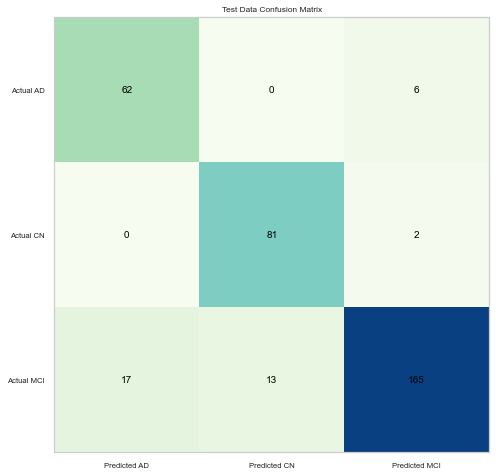

DT
========Model Evaluation Report========
Train Score:  0.8735549132947977
Test Score:  0.8959537572254336
Train BCA: 0.891 | Train AUC: 0.963
Test BCA: 0.908 | Test AUC: 0.961


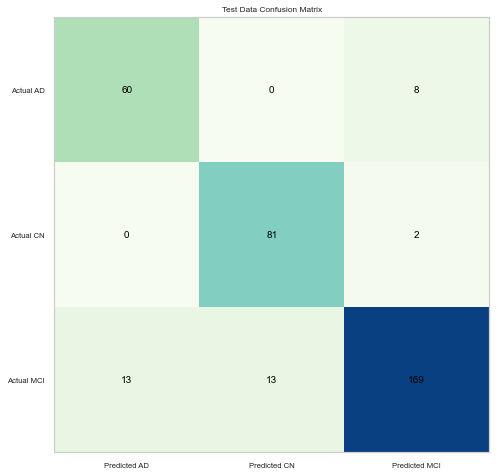

ANN
========Model Evaluation Report========
Train Score:  0.8728323699421965
Test Score:  0.9132947976878613
Train BCA: 0.875 | Train AUC: 0.966
Test BCA: 0.915 | Test AUC: 0.971


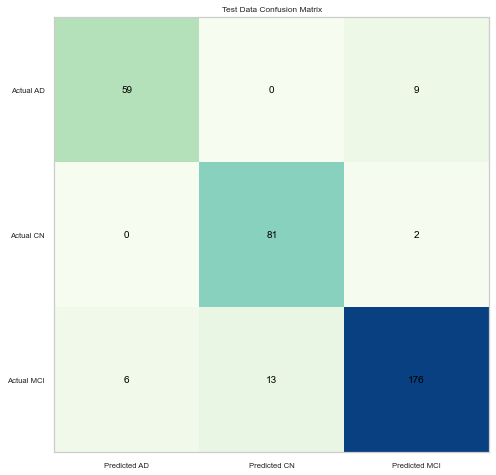

SVM
========Model Evaluation Report========
Train Score:  0.8713872832369942
Test Score:  0.8901734104046243
Train BCA: 0.894 | Train AUC: 0.959
Test BCA: 0.914 | Test AUC: 0.972


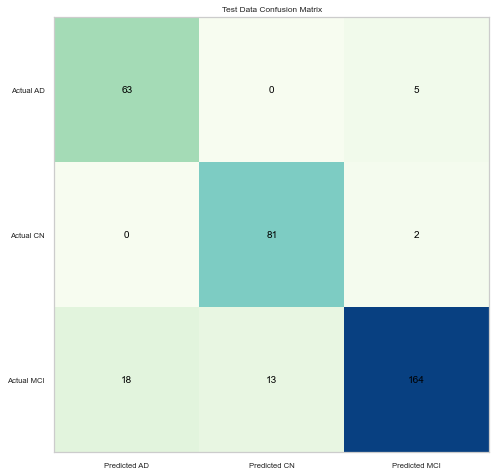

In [12]:
# evaluate
metrics = evaluate(baselearners)

### Stacking - Ensemble Learning: Model Training

Level 1 Classifiers - LRA, DT, ANN and SVM

Level 2 Classifier - LRA

In [13]:
# define level 1 estimators
estimators = [
    ('lra', lra),
    ('dt', dtc),
    ('ann', mlp),
    ('svm', svm)
]

In [14]:
# define and train stacking ensemble method
stk_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=2)
stk_clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 12 epochs took 0 seconds
Iteration 1, loss = 0.95681198
Iteration 2, loss = 0.88248505
Iteration 3, loss = 0.80195491
Iteration 4, loss = 0.72762823
Iteration 5, loss = 0.66007205
Iteration 6, loss = 0.60125585
Iteration 7, loss = 0.55236991
Iteration 8, loss = 0.51037104
Iteration 9, loss = 0.47476980
Iteration 10, loss = 0.44094609
Iteration 11, loss = 0.41652555
Iteration 12, loss = 0.39548525
Iteration 13, loss = 0.37941774
Iteration 14, loss = 0.37581819
Iteration 15, loss = 0.36412803
Iteration 16, loss = 0.36150325
Iteration 17, loss = 0.33929020
Iteration 18, loss = 0.34017339
Iteration 19, loss = 0.33365589
Iteration 20, loss = 0.32564785
Iteration 21, loss = 0.32278128
Iteration 22, loss = 0.31793893
Iteration 23, loss = 0.31703667
Iteration 24, loss = 0.31492397
Iteration 25, loss = 0.31493505
Iteration 26, loss = 0.31010620
Iteration 27, loss = 0.30995385
Iteration 28, loss = 0.30985240
Iteration 29, loss = 0.31482292
Iteration 30, loss = 0.31322978
Iterat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s rema

Iteration 16, loss = 0.40445261
Iteration 17, loss = 0.39142496
Iteration 18, loss = 0.38722830
Iteration 19, loss = 0.37638146
Iteration 20, loss = 0.36847434
Iteration 21, loss = 0.35930536
Iteration 22, loss = 0.35525922
Iteration 23, loss = 0.35067930
Iteration 24, loss = 0.34545395
Iteration 25, loss = 0.34102500
Iteration 26, loss = 0.33515097
Iteration 27, loss = 0.34167580
Iteration 28, loss = 0.34732106
Iteration 29, loss = 0.33481600
Iteration 30, loss = 0.33138158
Iteration 31, loss = 0.32626899
Iteration 32, loss = 0.32291763
Iteration 33, loss = 0.31866054
Iteration 34, loss = 0.31858580
Iteration 35, loss = 0.31612917
Iteration 36, loss = 0.31364106
Iteration 37, loss = 0.31530765
Iteration 38, loss = 0.31897706
Iteration 39, loss = 0.31397966
Iteration 40, loss = 0.31669414
Iteration 41, loss = 0.31454420
Iteration 42, loss = 0.30987606
Iteration 43, loss = 0.31143497
Iteration 44, loss = 0.31210211
Iteration 45, loss = 0.31183720
Iteration 46, loss = 0.31401346
Iteratio

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


Iteration 2, loss = 0.90282863
Iteration 3, loss = 0.82232998
Iteration 4, loss = 0.75857404
Iteration 5, loss = 0.69011518
Iteration 6, loss = 0.63377819
Iteration 7, loss = 0.58773852
Iteration 8, loss = 0.54903093
Iteration 9, loss = 0.51738199
Iteration 10, loss = 0.48615064
Iteration 11, loss = 0.46193174
Iteration 12, loss = 0.43854086
Iteration 13, loss = 0.41768326
Iteration 14, loss = 0.40198157
Iteration 15, loss = 0.38547154
Iteration 16, loss = 0.37658144
Iteration 17, loss = 0.36474006
Iteration 18, loss = 0.35485721
Iteration 19, loss = 0.35086747
Iteration 20, loss = 0.34133418
Iteration 21, loss = 0.33344477
Iteration 22, loss = 0.33192555
Iteration 23, loss = 0.33020716
Iteration 24, loss = 0.32968230
Iteration 25, loss = 0.33001047
Iteration 26, loss = 0.31642946
Iteration 27, loss = 0.31477045
Iteration 28, loss = 0.31299801
Iteration 29, loss = 0.31247093
Iteration 30, loss = 0.31133964
Iteration 31, loss = 0.31729142
Iteration 32, loss = 0.32084378
Iteration 33, lo

Iteration 40, loss = 0.28957476
Iteration 41, loss = 0.29142749
Iteration 42, loss = 0.28917298
Iteration 43, loss = 0.29002769
Iteration 44, loss = 0.28899191
Iteration 45, loss = 0.29314218
Iteration 46, loss = 0.28664546
Iteration 47, loss = 0.28508481
Iteration 48, loss = 0.28553411
Iteration 49, loss = 0.28495807
Iteration 50, loss = 0.28434318
Iteration 51, loss = 0.28868535
Iteration 52, loss = 0.28314676
Iteration 53, loss = 0.28610753
Iteration 54, loss = 0.28254759
Iteration 55, loss = 0.28138168
Iteration 56, loss = 0.28148245
Iteration 57, loss = 0.28241985
Iteration 58, loss = 0.28169333
Iteration 59, loss = 0.28595526
Iteration 60, loss = 0.28989041
Iteration 61, loss = 0.28292944
Iteration 62, loss = 0.28673459
Iteration 63, loss = 0.28608549
Iteration 64, loss = 0.28369120
Iteration 65, loss = 0.28034920
Iteration 66, loss = 0.28096563
Iteration 67, loss = 0.28930396
Iteration 68, loss = 0.28668472
Iteration 69, loss = 0.28772112
Iteration 70, loss = 0.28170397
Iteratio

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


StackingClassifier(cv=None,
                   estimators=[('lra',
                                LogisticRegression(C=3792.690190732246,
                                                   class_weight='balanced',
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='sag', tol=0.01,
                                                   verbose=2,
                                                   warm_start=False)),
                               ('dt',
                                De

========Model Evaluation Report========
Train Score:  0.8786127167630058
Test Score:  0.9190751445086706
Train BCA: 0.888 | Train AUC: 0.966
Test BCA: 0.925 | Test AUC: 0.972


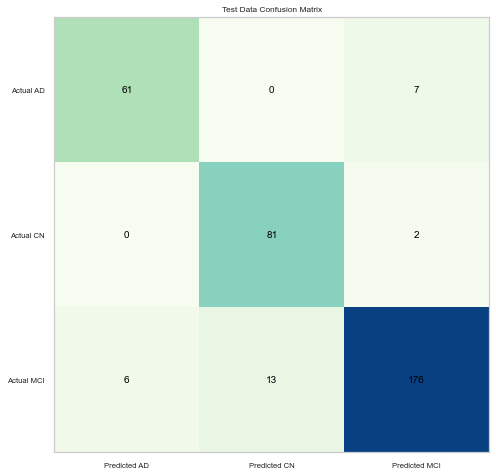

In [15]:
el_metrics = report(stk_clf)

### Save Best Model

In [16]:
model_name = "stacking_130620_1.pkl" #ensemble-date-modelversion

tp.save(stk_clf, model_name)

saving trained model


### Visualize Results

In [17]:
# add stacking results
metrics.append(['stacking'] + el_metrics)
# create results dataframe
results_df = pd.DataFrame(metrics, columns=['classifier', 'score_train', 'score_test', 'BCA_train', 'BCA_test', 
                                            'mAUC_train', 'mAUC_test'])

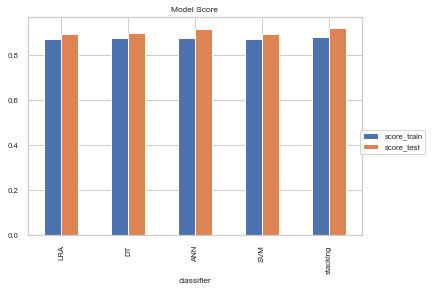

In [18]:
results_df.plot(x='classifier', y=['score_train', 'score_test'], kind='bar', 
                title='Model Score', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

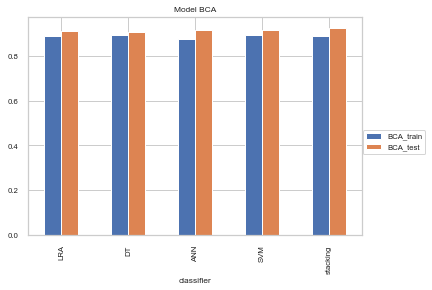

In [19]:
results_df.plot(x='classifier', y=['BCA_train', 'BCA_test'], kind='bar', 
                title='Model BCA', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

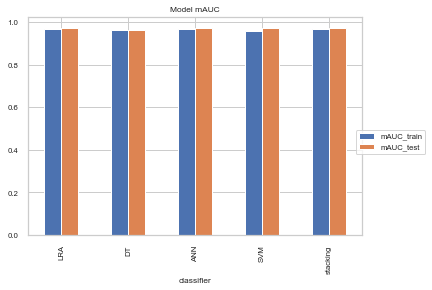

In [20]:
results_df.plot(x='classifier', y=['mAUC_train', 'mAUC_test'], kind='bar', 
                title='Model mAUC', grid=True).legend(bbox_to_anchor=(1.2, 0.5));

### Grid Search: Stacking

In [21]:
clf1 = LogisticRegression(class_weight='balanced')
clf2 = DecisionTreeClassifier(class_weight='balanced')
clf3 = MLPClassifier(learning_rate='adaptive')
clf4 = SVC(probability=True, class_weight='balanced')
lr = LogisticRegression(class_weight='balanced')
    
stk_params = {'logisticregression__C' : np.logspace(-4, 4, 10),
              'decisiontreeclassifier__max_depth' : [7, 8, 9, 10],       
              'mlpclassifier__hidden_layer_sizes' : [(50,50,50), (50,100,50), (100,)],
              'svc__C' : [1, 10, 100, 1000],
              'meta_classifier__C' : np.logspace(-4, 4, 10)}

In [22]:
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=lr,
                            random_state=43, use_probas=True, verbose=2)
stk_cv = tp.gridsearch(stk_params, sclf, scoring, n_jobs=10)

performing grid search
Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   19.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 11.2min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 16.2min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed: 22.0min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 29.0min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 36.7min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 45.1min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed: 54.7min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed: 64.4min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed: 74.2min
[Parallel(n_jobs=10)]: Done 7918 tasks      | elapsed: 84.7min
[Parallel(n_jobs=10)]: Done 9093 tasks      | 

Fitting 4 classifiers...
Fitting classifier1: logisticregression (1/4)
LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting classifier2: decisiontreeclassifier (2/4)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting classifier3: mlpclassifier (3/4)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting classifier4: svc (4/4)
SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [23]:
stk_cv.best_params_

{'decisiontreeclassifier__max_depth': 8,
 'logisticregression__C': 10000.0,
 'meta_classifier__C': 2.782559402207126,
 'mlpclassifier__hidden_layer_sizes': (50, 50, 50),
 'svc__C': 1}

========Model Evaluation Report========
Train Score:  0.8786127167630058
Test Score:  0.8872832369942196
Train BCA: 0.901 | Train AUC: 0.978
Test BCA: 0.910 | Test AUC: 0.970


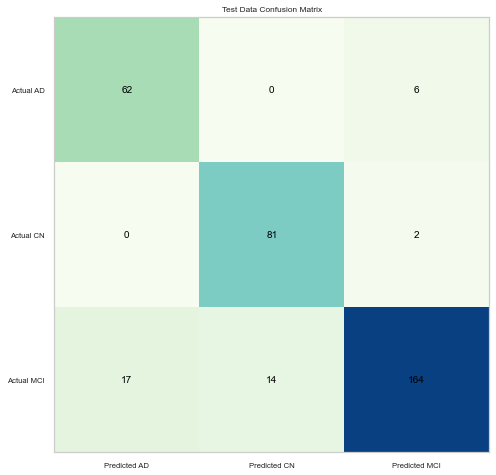

In [24]:
el_cv_metrics = report(stk_cv.best_estimator_)